# Twitter COVID-19 data analysis 

## Data preprocessing

Our preprocessing steps include:
- Dropping redundant columns
- Dropping columns that contain too many missing values
- Dropping all rows that contain missing values 
- Dropping all duplicated rows
- Removing all hyperlinks, mentions, hashtags, newline characters, non-text characters, and trailing space from the tweets and converting them to lowercase. 
- Converting the "createdAt" column containing timestamps from object datatype to pandas datetime datatype
- Assigning new IDs to tweets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import string
import re
from textblob import TextBlob
from collections import Counter
import liwc

In [3]:
df = pd.read_csv("TweetsAboutCovid-19.csv")
df.head()

C:\Users\dunga\AppData\Local\Temp\ipykernel_2812\1856666418.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TweetsAboutCovid-19.csv")


,id,created_at,date,time,timezone,place,tweet,language,replies_count,retweets_count,likes_count,hashtags,cashtags,retweet,video,thumbnail
0,1.385880e+18,2021-04-24 08:43:17 UTC,4/24/2021,8:43:17,0,NaN,🇨🇺: ✍️ Covid-19 en Cuba: 1241 nuevos casos pos...,es,0.0,0.0,0.0,"['reportando', 'cuba']",[],False,0.0,NaN
1,1.385880e+18,2021-04-24 08:43:17 UTC,4/24/2021,8:43:17,0,NaN,The latest The Zika Advice Paper! https://t.c...,en,0.0,0.0,0.0,"['covid19', 'amr']",[],False,0.0,NaN
2,1.385880e+18,2021-04-24 08:43:16 UTC,4/24/2021,8:43:16,0,NaN,Tum karo toh mantra ..woh kare toh tantra ..ai...,tl,0.0,0.0,0.0,"['covidindia', 'covidvaccine', 'covidresources...",[],False,1.0,https://pbs.twimg.com/media/EzufwnkUYA0TExx.jpg
3,1.385880e+18,2021-04-24 08:43:16 UTC,4/24/2021,8:43:16,0,NaN,https://t.co/4rdhSH3IYl Prime Minister @Nare...,en,0.0,0.0,0.0,['covid_19'],[],False,1.0,https://pbs.twimg.com/media/EzueSRxVgAEiTie.jpg
4,1.385880e+18,2021-04-24 08:43:16 UTC,4/24/2021,8:43:16,0,NaN,@bc_pt64 @KackCake @sherlockine1 @SternchenJvB...,de,0.0,0.0,0.0,[],[],False,0.0,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803645 entries, 0 to 803644
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              803645 non-null  float64
 1   created_at      803645 non-null  object 
 2   date            803645 non-null  object 
 3   time            803645 non-null  object 
 4   timezone        803645 non-null  int64  
 5   place           880 non-null     object 
 6   tweet           803645 non-null  object 
 7   language        803644 non-null  object 
 8   replies_count   803644 non-null  float64
 9   retweets_count  803644 non-null  float64
 10  likes_count     803644 non-null  float64
 11  hashtags        803644 non-null  object 
 12  cashtags        803644 non-null  object 
 13  retweet         803644 non-null  object 
 14  video           803644 non-null  float64
 15  thumbnail       232981 non-null  object 
dtypes: float64(5), int64(1), object(10)
memory usage: 98.1+ 

Columns "place" and "thumbnail" have too many NA values, while other columns only have a few NA values. We'll drop columns "place" and "thumbnail" and proceed to drop all rows that contain any missing data.

In [5]:
df.drop(columns=["place", "thumbnail"], inplace=True)

In [6]:
df.nunique()

id                   117
created_at        251871
date                   4
time               86329
timezone               1
tweet             780154
language              64
replies_count        428
retweets_count      1094
likes_count         1918
hashtags          174467
cashtags             579
retweet                1
video                  2
dtype: int64

Columns "retweet" and "timezone" only have 1 unique value. Column "id" only have 117 unique values, but each observation in the dataframe should have a unique ID.

We'll drop columns "timezone" and "retweet" and investigate the "id" column. 

In [7]:
df.drop(columns=["timezone", "retweet"], inplace=True)

In [8]:
df.dropna(inplace=True)

In [9]:
df["id"].head()

0    1.385880e+18
1    1.385880e+18
2    1.385880e+18
3    1.385880e+18
4    1.385880e+18
Name: id, dtype: float64

In [10]:
df["id"].dtype

dtype('float64')

Notice that the "id" column contains very few unique values compared to the number of posts we have. Furthermore, they are all floats, which is unreasonable for IDs. This might be due to a problem during dataset construction - the ID column might have been automatically converted to numbers (floats) even though they are supposed to be interpreted as strings. We'll discard the old IDs and use the current index of each tweet as its ID. There shouldn't be any problem as long as the IDs are unique for each tweet. 

In [11]:
df["id"] = range(len(df))

Let's drop all duplicated rows.

In [12]:
df.drop_duplicates(inplace=True)

Let's clean the tweets.

In [13]:
def pre_processing(text):
    # Remove hyperlinks from the tweet
    text = re.sub(r'https?:\/\/\S+', '', text)
    
    # Remove @mentions, which are specific to Twitter posts
    text = re.sub(r'@[A-Za-z0-9]+', '', text)

    # Remove #hashtags, which are specific to Twitter posts
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    
    # Remove newline escape sequences (like \n) from the tweet
    # to ensure the tweet text doesn't contain any line breaks
    text = re.sub(r'\n','', text) 

    # Keep only letters and numbers. 
    # All other characters are replaced with a space.
    text = re.sub(r"[^A-Za-z0-9#]+", ' ', text)
    
    # Remove any extra spaces between words and any trailing or leading spaces
    text = re.sub(r'\s+', ' ', text).strip().lower()
    
    return text

df['clean_tweet'] = df['tweet'].apply(pre_processing)

Let's convert the "created_at" timestamps into pandas datetime datatype.

In [14]:
df["created_at"] = pd.to_datetime(df["created_at"])

In [15]:
df.reset_index(inplace=True, drop=True)

## Exploratory Data Analysis

Let's explore the most popular languages of the tweets.

In [16]:
# group by language and counting
n_tweets_by_lang = df.groupby("language").count()["id"].reset_index()
n_tweets_by_lang.columns = ["language", "count"]
n_tweets_by_lang.sort_values("count", ascending=False)[:10]

,language,count
12,en,412115
13,es,131519
24,in,40841
46,pt,33253
20,hi,28140
18,fr,26546
9,de,22139
60,und,19622
28,ja,17672
58,tr,11376


<Axes: xlabel='language', ylabel='count'>

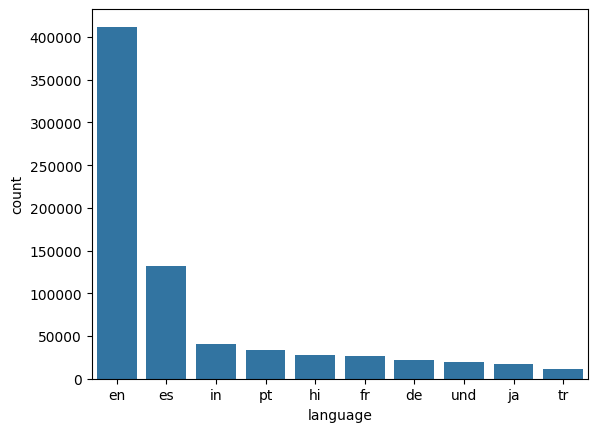

In [17]:
# plotting top 10 most common languages and their tweet counts
sns.barplot(n_tweets_by_lang.sort_values("count", ascending=False)[:10], x="language", y="count")

We'll next explore the distribution of the word count of the tweets.

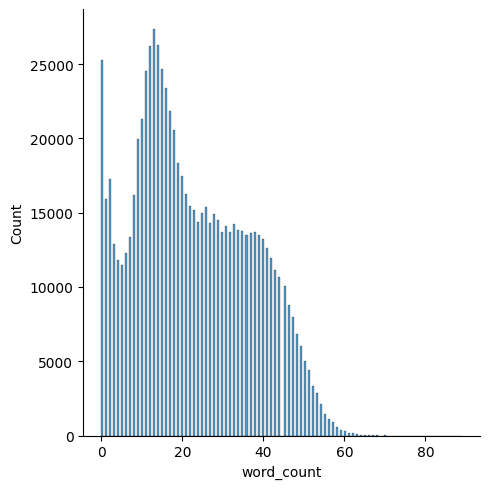

In [18]:
# calculating word counts of clean tweets and plotting the distribution
df["word_count"] = df["clean_tweet"].apply(lambda x: len(x.split()))
sns.displot(df["word_count"])

## Post activity by hour

In this section, we explore how the post activity changes on a hourly basis throughout the study period. We first aggregated the tweets count by date-hour, aggregated the tweets count by hour, and calculated the proportion of tweets count per hour.  

In [19]:
df["date"].unique()

array(['4/24/2021', '4/23/2021', '4/22/2021', '4/21/2021'], dtype=object)

In [20]:
# group by date and hour and count the number of tweets
df["hour"] = df["created_at"].apply(lambda x: x.hour)
n_tweets_date_hour = df.groupby(["date", "hour"]).count()["id"].reset_index()
n_tweets_date_hour.columns = ["date", "hour", "count"]
n_tweets_date_hour["date-time"] = pd.to_datetime(n_tweets_date_hour["date"] + " " + n_tweets_date_hour["hour"].astype(str) + ":00")
n_tweets_date_hour.head()

,date,hour,count,date-time
0,4/21/2021,4,4807,2021-04-21 04:00:00
1,4/21/2021,5,7016,2021-04-21 05:00:00
2,4/21/2021,6,7559,2021-04-21 06:00:00
3,4/21/2021,7,9419,2021-04-21 07:00:00
4,4/21/2021,8,8158,2021-04-21 08:00:00


<Axes: xlabel='date-time', ylabel='count'>

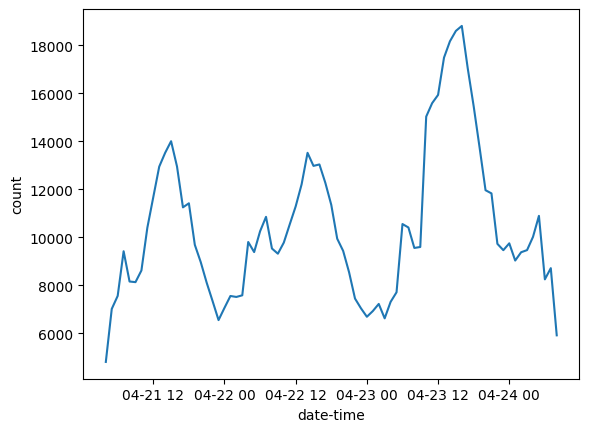

In [21]:
# plotting the number of tweets per hour throughout the study period (4 days)
sns.lineplot(n_tweets_date_hour, x="date-time", y="count")

In [41]:
# group by hour and calculating the proportion of tweets each hour
n_tweets_hour = n_tweets_date_hour.groupby("hour")["count"].sum().reset_index()
n_tweets_hour["prop"] = n_tweets_hour["count"]/sum(n_tweets_hour["count"])
n_tweets_hour.head()

,hour,count,prop
0,0,23500,0.029242
1,1,23513,0.029258
2,2,24117,0.030010
3,3,23673,0.029457
4,4,31940,0.039744


<Axes: xlabel='hour', ylabel='prop'>

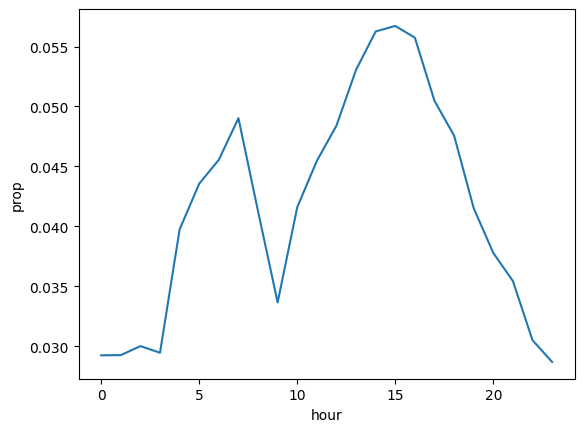

In [42]:
sns.lineplot(n_tweets_hour, x="hour", y="prop")

We can see a clear seasonal pattern in the time series data with a period of one day.

## Text frequency analysis

We'll first explore the most commonly used hashtags. We'll remove all punctuations from the hashtags and count the number of each hashtag.

In [24]:
# remove punctuations from hashtags
translator = str.maketrans("", "", string.punctuation)
df["hashtags"] = df["hashtags"].apply(lambda x: x.translate(translator).strip().lower().split())
all_hashtags = {}
# count the number of occurrences of each hashtag
for i in range(len(df)):
    tags = df["hashtags"][i]
    for tag in tags:
        if tag in all_hashtags:
            all_hashtags[tag] += 1
        else:
            all_hashtags[tag] = 1
hashtag_df = pd.DataFrame.from_dict(all_hashtags, orient="index").reset_index()
hashtag_df.columns = ["hashtag", "count"]
# sorting the counts
hashtag_df.sort_values("count", ascending=False)[:15]

,hashtag,count
2,covid19,241301
36,coronavirus,25731
21,covid,15460
20,corona,10338
7,covidemergency2021,10308
13,india,7925
149,covid19india,7365
4,covidindia,7028
8,vaccine,6181
34,coronaviruspandemic,5423


C:\Users\dunga\AppData\Local\Temp\ipykernel_2812\391769964.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45,


<Axes: xlabel='hashtag', ylabel='count'>

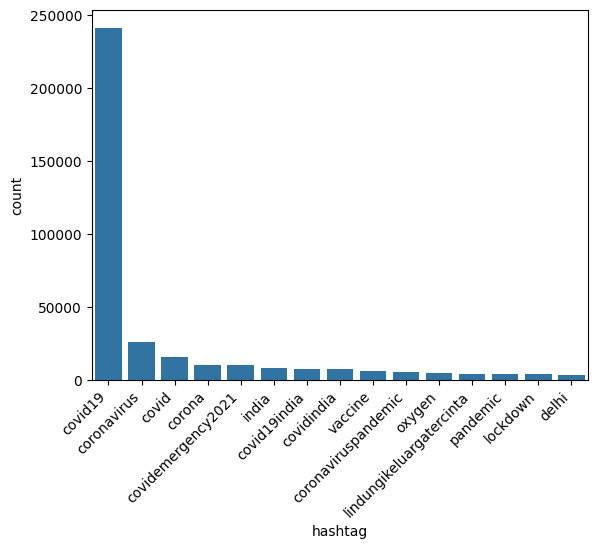

In [25]:
# plotting the counts of 15 most common hashtags
plot = sns.barplot(hashtag_df.sort_values("count", ascending=False)[:15], x="hashtag", y="count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45,
                        horizontalalignment='right')
plot

Next, we'll explore the most common words in English tweets. To do this, we tokenized (split on space) each clean_tweet to obtain a list of words, removed the stop words, lemmatized each word, and then counted the number of occurrences of each word.

In [26]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt') 
nltk.download('stopwords')
nltk_stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     WRONG_VERSION_NUMBER] wrong version number
[nltk_data]     (_ssl.c:1000)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     WRONG_VERSION_NUMBER] wrong version number
[nltk_data]     (_ssl.c:1000)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     WRONG_VERSION_NUMBER] wrong version number
[nltk_data]     (_ssl.c:1000)>


False

In [27]:
# filtered out non-english tweets, saving the english ones in a new df
df_en_tweets = df[df["language"] == "en"].copy()
df_en_tweets.reset_index(drop=True, inplace=True)

In [28]:
# tokenize
df_en_tweets["tokenized_tweets"] = df_en_tweets["clean_tweet"].apply(lambda x: x.split())
# remove stop words
df_en_tweets["tokenized_rm_sw_tweets"] = df_en_tweets["tokenized_tweets"].apply(lambda x: [w for w in x if w not in nltk_stop_words])
# lemmatize
lemmatizer = WordNetLemmatizer()
df_en_tweets["root"] = df_en_tweets["tokenized_rm_sw_tweets"].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

In [29]:
df_en_tweets.head()

,id,created_at,date,time,tweet,language,replies_count,retweets_count,likes_count,hashtags,cashtags,video,clean_tweet,word_count,hour,tokenized_tweets,tokenized_rm_sw_tweets,root
0,1,2021-04-24 08:43:17+00:00,4/24/2021,8:43:17,The latest The Zika Advice Paper! https://t.c...,en,0.0,0.0,0.0,"[covid19, amr]",[],0.0,the latest the zika advice paper thanks to,8,8,"[the, latest, the, zika, advice, paper, thanks...","[latest, zika, advice, paper, thanks]","[latest, zika, advice, paper, thanks]"
1,3,2021-04-24 08:43:16+00:00,4/24/2021,8:43:16,https://t.co/4rdhSH3IYl Prime Minister @Nare...,en,0.0,0.0,0.0,[covid19],[],1.0,prime minister on saturday said that like last...,23,8,"[prime, minister, on, saturday, said, that, li...","[prime, minister, saturday, said, like, last, ...","[prime, minister, saturday, said, like, last, ..."
2,5,2021-04-24 08:43:16+00:00,4/24/2021,8:43:16,Covid-19: India is going through very terrible...,en,0.0,0.0,0.0,"[presssangharsh, dailynews, news, india, corev...",[],1.0,covid 19 india is going through very terrible ...,13,8,"[covid, 19, india, is, going, through, very, t...","[covid, 19, india, going, terrible, situation,...","[covid, 19, india, going, terrible, situation,..."
3,6,2021-04-24 08:43:15+00:00,4/24/2021,8:43:15,@CPBlr @KamalPantIPS speaks to me on the rules...,en,0.0,0.0,0.0,[covid19],[],0.0,speaks to me on the rules that people will hav...,40,8,"[speaks, to, me, on, the, rules, that, people,...","[speaks, rules, people, follow, volunteers, be...","[speaks, rule, people, follow, volunteer, beng..."
4,7,2021-04-24 08:43:14+00:00,4/24/2021,8:43:14,@Physio_voice @BiswabhusanHC @ysjagan @Audimul...,en,0.0,0.0,0.0,[],[],0.0,voice namaste sir we are the ntruhs physiother...,38,8,"[voice, namaste, sir, we, are, the, ntruhs, ph...","[voice, namaste, sir, ntruhs, physiotherapy, s...","[voice, namaste, sir, ntruhs, physiotherapy, s..."


In [30]:
# count the number of occurrences of each word
tweet_words = {}
for i in range(len(df_en_tweets)):
    for w in df_en_tweets["root"][i]:
        if w in tweet_words:
            tweet_words[w] += 1
        else:
            tweet_words[w] = 1

In [31]:
len(tweet_words)

123298

In [32]:
# sorting the counts
tweet_words_df = pd.DataFrame.from_dict(tweet_words, "index").reset_index()
tweet_words_df.columns = ["word", "count"]
tweet_words_df.sort_values("count", ascending=False)[:30]

,word,count
20,covid,266275
13,19,263436
318,vaccine,70663
57,case,50743
117,amp,47003
21,india,41491
31,people,37642
281,new,35522
329,u,29589
93,pandemic,28105


C:\Users\dunga\AppData\Local\Temp\ipykernel_2812\3193980282.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45,


<Axes: xlabel='word', ylabel='count'>

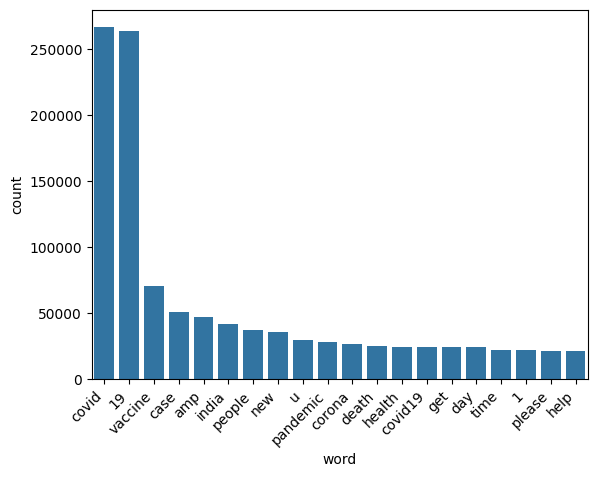

In [33]:
# plotting the counts of the most frequent words
plot = sns.barplot(tweet_words_df.sort_values("count", ascending=False)[:20], x="word", y="count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45,
                        horizontalalignment='right')
plot

## Sentiment analysis

In this section, we perform sentiment analysis on the English tweets. We first used TextBlob to extract the subjectivity of each tweet, then used VADER to infer the polarity of each tweet.

<Axes: xlabel='subjectivity', ylabel='Count'>

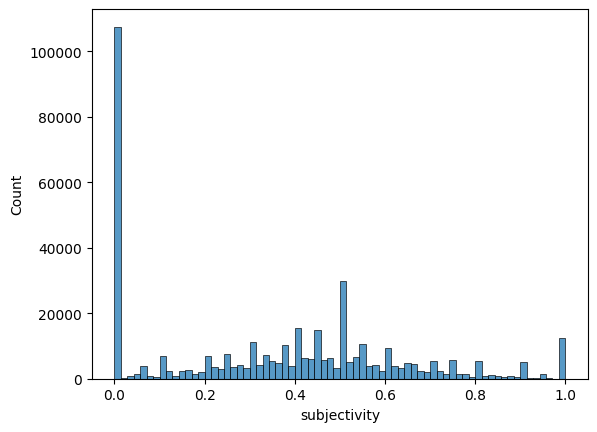

In [34]:
# extracting tweet subjectivity and plotting the distribution of the subjectivity score
sentiments = df_en_tweets["tweet"].apply(lambda x: TextBlob(x).sentiment)
df_en_tweets["subjectivity"] = sentiments.apply(lambda s: s.subjectivity)
sns.histplot(df_en_tweets["subjectivity"])

<Axes: xlabel='polarity', ylabel='Count'>

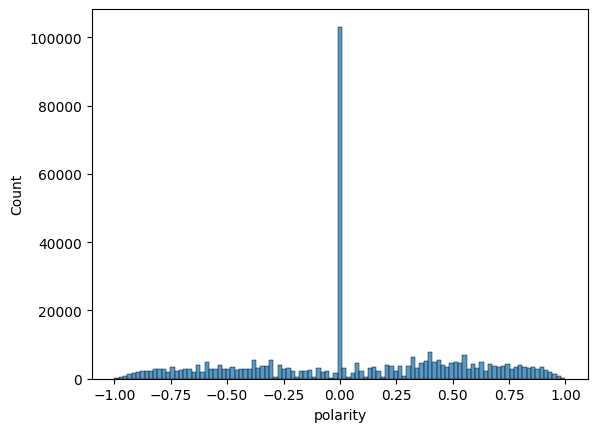

In [35]:
# extracting polarity score of each tweet and plotting the distribution of the score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader_analyzer= SentimentIntensityAnalyzer()
df_en_tweets["polarity"] = df_en_tweets["tweet"].apply(lambda x: vader_analyzer.polarity_scores(x)["compound"])
sns.histplot(df_en_tweets["polarity"])

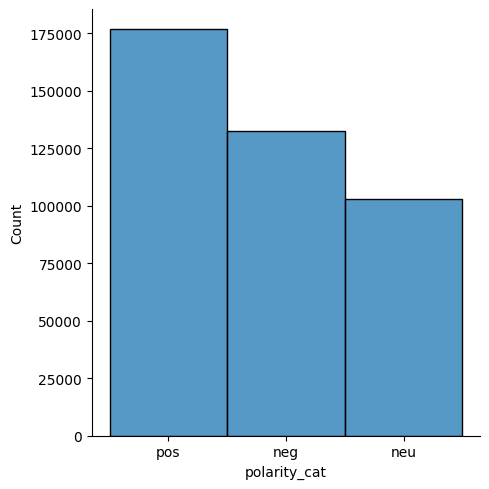

In [36]:
# dividing the tweets into 3 categories based on their polarity score
df_en_tweets["polarity_cat"] = df_en_tweets["polarity"].apply(lambda x: "pos" if x > 0 else "neu" if x == 0 else "neg")
# plotting the distribution of the polarity categories
sns.displot(df_en_tweets["polarity_cat"])

## Linguistic Inquiry and Word Count (LIWC)

In [37]:
# loading parser and category names
parse, category_names = liwc.load_token_parser('LIWC.dic')
# parsing each token and recording its category
liwc_df = df_en_tweets["root"].apply(lambda tokens: dict(Counter(category for token in tokens for category in parse(token))))
# counting the number of occurrences of each category
def fun(counts):
    for cat in category_names:
        if cat not in counts:
            counts[cat] = 0
    return counts
liwc_df = liwc_df.apply(fun)
liwc_df = pd.DataFrame(list(liwc_df))
liwc_df.head()

,relativ,time,social,work,verbs,present,affect,posemo,funct,pronoun,...,space,achiev,leisure,home,money,relig,death,assent,nonflu,filler
0,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,4,1,1,1,0,2,2,0,0,...,1,1,0,0,0,1,0,0,0,1
2,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,1,3,2,1,1,1,1,0,0,...,1,0,1,1,0,0,0,0,0,0
4,4,3,2,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
# sorting the counts to obtain 20 most common word categories 
liwc_df.sum().sort_values(ascending=False)[:20]

relativ    873577
cogmech    642508
affect     465168
time       433685
social     396598
funct      382979
verbs      371300
work       366957
posemo     281954
bio        245177
space      236220
present    227639
achiev     208198
negemo     189668
health     183750
insight    148239
cause      124769
quant      113054
percept    110763
inhib      101530
dtype: int64

## Statistical analysis 

In this section, we'll explore the relationship between the semantic group and popularity (likes count, replies count, retweets count) of a tweet. In particular, we'll conduct one-way ANOVA tests for any difference in the average likes count, replies count, and comments count between the three groups positive tweets, neutral tweets, and negative tweets. If a difference is detected, we'll conduct a Tukey's HSD test to idenitfy the pairs whose means are different from each other. 

In [39]:
from scipy.stats import f_oneway, tukey_hsd

In [50]:
# calculating the means of likes_count, replies_count, and retweets_count by polarity group
df_en_tweets[["likes_count", "replies_count", "retweets_count", "polarity_cat"]].groupby("polarity_cat").mean()

,likes_count,replies_count,retweets_count
polarity_cat,,,
neg,16.356879,1.211664,4.846210
neu,10.886316,1.009376,3.169413
pos,13.821792,1.065628,4.129683


In [43]:
# divide the df_en_tweets into 3 smaller dataframes based on the polarity categories
pos = df_en_tweets[df_en_tweets["polarity_cat"] == "pos"]
neu = df_en_tweets[df_en_tweets["polarity_cat"] == "neu"]
neg = df_en_tweets[df_en_tweets["polarity_cat"] == "neg"]

In [44]:
# ANOVA for likes count
f_oneway(pos["likes_count"], neu["likes_count"], neg["likes_count"])

F_onewayResult(statistic=5.165359622513509, pvalue=0.0057113784083803925)

In [48]:
# Difference detected, conducting Tukey's HSD
print(tukey_hsd(pos["likes_count"], neu["likes_count"], neg["likes_count"]))

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      2.935     0.161    -0.831     6.702
 (0 - 2)     -2.535     0.204    -6.025     0.955
 (1 - 0)     -2.935     0.161    -6.702     0.831
 (1 - 2)     -5.471     0.004    -9.462    -1.479
 (2 - 0)      2.535     0.204    -0.955     6.025
 (2 - 1)      5.471     0.004     1.479     9.462



In [45]:
# ANOVA for replies count
f_oneway(pos["replies_count"], neu["replies_count"], neg["replies_count"])

F_onewayResult(statistic=1.1665389279848248, pvalue=0.3114440329857995)

In [46]:
# ANOVA for retweets count
f_oneway(pos["retweets_count"], neu["retweets_count"], neg["retweets_count"])

F_onewayResult(statistic=16.396916020778075, pvalue=7.571695972042705e-08)

In [49]:
# Difference detected, conducting Tukey's HSD
print(tukey_hsd(pos["retweets_count"], neu["retweets_count"], neg["retweets_count"]))

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.960     0.001     0.313     1.608
 (0 - 2)     -0.717     0.014    -1.317    -0.116
 (1 - 0)     -0.960     0.001    -1.608    -0.313
 (1 - 2)     -1.677     0.000    -2.363    -0.990
 (2 - 0)      0.717     0.014     0.116     1.317
 (2 - 1)      1.677     0.000     0.990     2.363

